In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from langdetect import detect, DetectorFactory
from spellchecker import SpellChecker
from tqdm import tqdm
tqdm.pandas()
import numpy as np
from matplotlib.ticker import MaxNLocator
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zsolnai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv("data/train.csv")

# Class imbalance

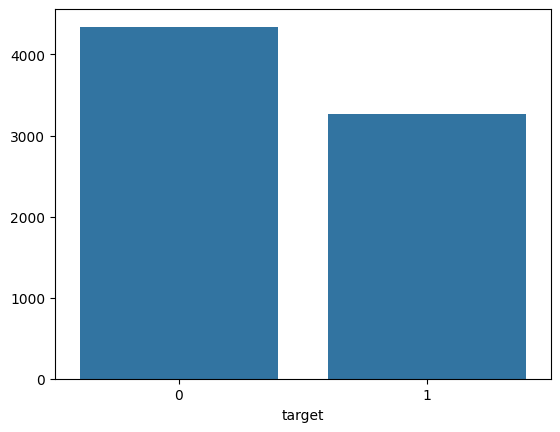

In [3]:
counts = data['target'].value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.show()

# Get golden standard data

In [4]:
url = "https://en.wikipedia.org/wiki/Natural_disaster"

response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    
    paragraphs = soup.find_all('p')
    article_text = "\n".join([para.get_text() for para in paragraphs])

# Examine language of tweets

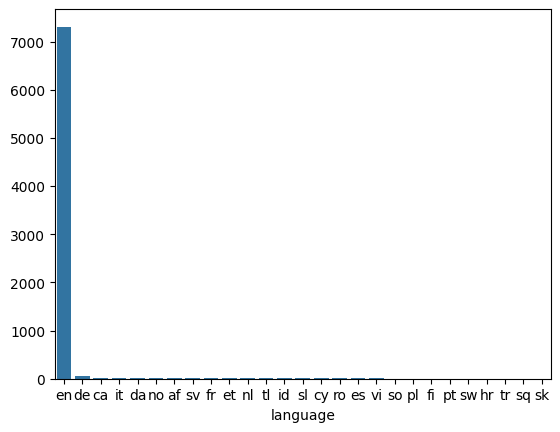

In [5]:
DetectorFactory.seed = 0

data["language"] = data["text"].apply(lambda text: detect(text))

counts = data["language"].value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.show()

In [6]:
data[~(data["language"] == "en")]

,id,keyword,location,text,target,language
16,24,NaN,NaN,I love fruits,0,fr
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,so
22,33,NaN,NaN,Love skiing,0,sl
24,36,NaN,NaN,LOOOOOOL,0,fr
26,38,NaN,NaN,Was in NYC last week!,0,af
...,...,...,...,...,...,...
7415,10608,wounded,NaN,DESCRIPTIONS OF 'WOUNDED CATS BEING 'EXCITING'...,0,de
7470,10687,wreck,NaN,I am a wreck,0,pl
7472,10689,wreck,NaN,wreck? wreck wreck wreck wreck wreck wreck wre...,0,pl
7495,10722,wreck,"Greenville, S.C.",Greer man dies in wreck http://t.co/n2qZbMZuly,1,af


It looks like the "non-english-texts" are just incorrectly identified. Most likely all tweets are in english.

# Text quality metrics

## Spelling mistakes

In [7]:
spell = SpellChecker()

### Wiki article

In [8]:
num_words = len(article_text.split())
num_mispelled = len(spell.unknown(article_text.split()))
mispelled_ratio = num_mispelled / num_words
print(f"Mispelled ratio for article: {mispelled_ratio}")

Mispelled ratio for article: 0.13364746198329408


### Disaster dataset

In [9]:
data["num_words"] = data["text"].apply(lambda text: len(text.split()))
data["num_mispelled"] = data["text"].apply(lambda text: len(spell.unknown(text.split())))

In [10]:
sum(data["num_mispelled"]) / sum(data["num_words"])

0.2623720926133209

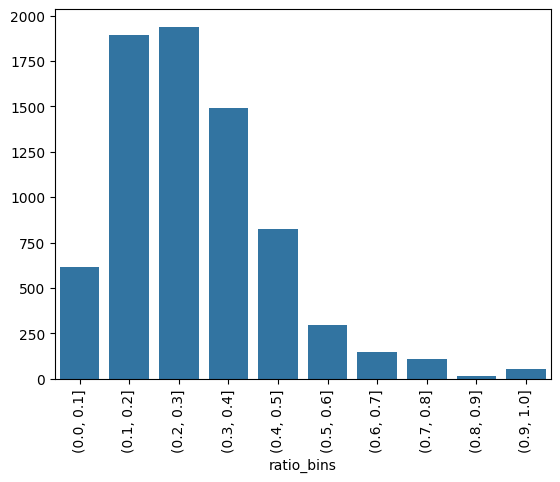

In [11]:
data["mispelled_ratio"] = data["num_mispelled"] / data["num_words"]

counts = data["mispelled_ratio"].value_counts()

bin_edges = np.arange(0, 1.1, 0.1)

data['ratio_bins'] = pd.cut(data['mispelled_ratio'], bins=bin_edges)

counts = data['ratio_bins'].value_counts().sort_index()

sns.barplot(x=counts.index, y=counts.values)
plt.xticks(rotation=90)
plt.show()

In [12]:
data["mispelled_ratio"]

0       0.153846
1       0.285714
2       0.136364
3       0.375000
4       0.125000
          ...   
7608    0.090909
7609    0.250000
7610    0.625000
7611    0.210526
7612    0.307692
Name: mispelled_ratio, Length: 7613, dtype: float64

In [13]:
data.sort_values(by="mispelled_ratio", ascending=False)[["mispelled_ratio", "text"]].iloc[:30]

,mispelled_ratio,text
24,1.0,LOOOOOOL
28,1.0,Cooool :)
848,1.0,@LoneWolffur BRUH *dies*
783,1.0,@kynespeace *blight
5353,1.0,Photo: deadgirltalking: unfortunemelody: jayle...
4873,1.0,@BenignoVito @LibertyBell1000 HILLARYMASS MURD...
4504,1.0,hurricane?? sick!
5331,1.0,#Pandemonium.iso psp http://t.co/HbpNFOAwII
6999,1.0,@carolinagutierr grande twister!!!
6907,1.0,I'm traumatised???? @megancoopy @laurathorne97...


## Grammar mistakes

TODO

# Information content

## Ratio of stopwords

In [14]:
def compute_stopwords_ratio(text):
    words = text.split()
    stopwords_count = sum(1 for word in words if word in stop_words)
    return stopwords_count / len(words)

In [15]:
print(f"Wiki stopwords ratio: {compute_stopwords_ratio(article_text)}")

Wiki stopwords ratio: 0.359391732705076


In [16]:
data['stopwords_ratio'] = data['text'].apply(compute_stopwords_ratio)
print(f"Average stopword ratio: {np.mean(data['stopwords_ratio'])}")

Average stopword ratio: 0.2286642259954742


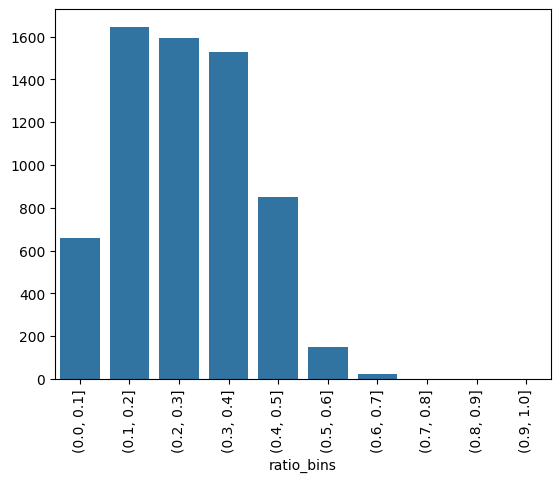

In [17]:
counts = data["stopwords_ratio"].value_counts()

bin_edges = np.arange(0, 1.1, 0.1)

data['ratio_bins'] = pd.cut(data['stopwords_ratio'], bins=bin_edges)

counts = data['ratio_bins'].value_counts().sort_index()

sns.barplot(x=counts.index, y=counts.values)
plt.xticks(rotation=90)
plt.show()

In [18]:
data.sort_values(by="stopwords_ratio", ascending=True)[["stopwords_ratio", "text"]].iloc[:30]

,stopwords_ratio,text
30,0.0,The end!
7421,0.0,@wocowae Police Officer Wounded Suspect Dead A...
7423,0.0,Police Officer Wounded Suspect Dead After Exch...
7426,0.0,Police Officer Wounded Suspect Dead After Exch...
24,0.0,LOOOOOOL
7430,0.0,ABC News: Police Officer Wounded Suspect Dead ...
104,0.0,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...
106,0.0,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...
7587,0.0,Sirens everywhere!
93,0.0,Aashiqui Actress Anu Aggarwal On Her Near-Fata...


# Average tf-idf scores

In [19]:
# Assuming 'text' is the column in your DataFrame that contains the text
vectorizer = TfidfVectorizer()

vectorizer.fit(list(data['text']) + list(article_text))

tfidf_matrix = vectorizer.transform(data['text'])


# Compute the average tf-idf score for each text
avg_tfidf_scores = np.squeeze(np.asarray(tfidf_matrix.mean(axis=1)))

# Append it to the dataframe
data['avg_tfidf'] = avg_tfidf_scores

# Calculate and print the average tf-idf for the entire dataset
dataset_avg_tfidf = np.mean(avg_tfidf_scores)
print(f"Average tf-idf score for the dataset: {dataset_avg_tfidf}")

# 'article_text' is your variable that contains some text in string format
# To transform it into a tf-idf vector, we first need to put it in a list
article_vect = vectorizer.transform([article_text])

# Compute the average tf-idf score for the article
article_avg_tfidf = np.mean(article_vect.toarray())
print(f"Average tf-idf score for the article: {article_avg_tfidf}")


Average tf-idf score for the dataset: 0.00016578939710458506
Average tf-idf score for the article: 0.0006681340201725849


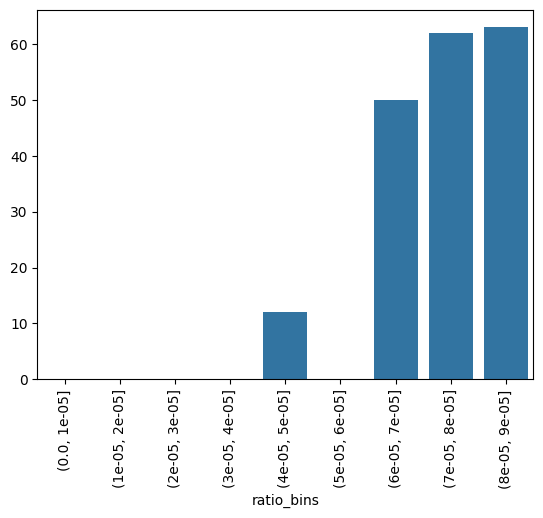

In [20]:
counts = data["avg_tfidf"].value_counts()

bin_edges = np.arange(0, 0.0001, 0.00001)

data['ratio_bins'] = pd.cut(data['avg_tfidf'], bins=bin_edges)

counts = data['ratio_bins'].value_counts().sort_index()

sns.barplot(x=counts.index, y=counts.values)
plt.xticks(rotation=90)
plt.show()

In [21]:
data.sort_values(by="avg_tfidf", ascending=True)[["avg_tfidf", "text"]].iloc[:30]

,avg_tfidf,text
24,0.000046,LOOOOOOL
28,0.000046,Cooool :)
4971,0.000046,Meltdown
3696,0.000046,Fatality ????
5184,0.000046,Obliterated
6522,0.000046,:: Survive??
3670,0.000046,fatality
3667,0.000046,Fatality!
1882,0.000046,Crushed
6705,0.000046,Thunder???


## Unknown BERT tokens

In [22]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def count_unknowns(text):
    tokenized_text = tokenizer.tokenize(text)
    unknown_tokens = [token for token in tokenized_text if token == "[UNK]"]
    return len(unknown_tokens)


data['unknowns_count'] = data['text'].progress_apply(count_unknowns)


average_unknowns = data['unknowns_count'].mean()
print(f"Average number of unknown tokens in texts: {average_unknowns}")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/zsolnai/miniconda3/envs/disaster_tweets3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/zsolnai/miniconda3/envs/disaster_tweets3/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/zsolnai/miniconda3/envs/disaster_tweets3/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/zsolnai/miniconda3/envs/disaster_tweets3/lib/python3.10/sit

Average number of unknown tokens in texts: 0.0


# Outliers

In [23]:
'''
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(data['text'].tolist(), convert_to_tensor=True)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

embeddings_np = embeddings.numpy()

clusters = kmeans.fit_predict(embeddings_np)

from sklearn.manifold import TSNE

# Use t-SNE to reduce the dimensionality of the embeddings to 2D
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)

# `embeddings_2d` is a 2D tensor where each row is a 2D representation of a text in your dataset

import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for seaborn
plot_data = pd.DataFrame(embeddings_2d, columns=["Dim1", "Dim2"])
plot_data['Target'] = data['target'].values  # This assumes your "target" column is accessible here

# Create a scatter plot
plt.figure(figsize=(10, 10))
sns.scatterplot(data=plot_data, x="Dim1", y="Dim2", hue="Target", palette="deep")

plt.show()
'''